# Third research question results

RQ1 and RQ2 study how inputs affect (1) performance distributions and (2) the effects of different configuration options. 
However, the performance distributions could change in a negligible way, without affecting the software user's experience. 
Before concluding on the real impact of the input sensitivity, it is necessary to quantify how much this performance changes from one input to another. 
Next, we ask whether adapting the software to its input data is worth the cost of finding the right set of parameters \ie the concrete impact of input sensitivity. 


## RQ3 - Can we ignore input sensitivity?


To estimate how much we can lose, we first define two scenarios S1 and S2:

- *S1 - Baseline.* In this scenario, we just train a simple performance model on an input - i.e. the *target* input. We choose the best configuration according to the model, configure the related software with it and execute it with the target input.
- *S2 - Ignoring input sensitivity.* In this scenario, we train a model on a given input i.e. the *source* input, and then predict the best configuration for this source input. If we ignore the threat of input sensitivity, we can easily reuse this model for any other input, including the target input defined in S1. Finally, we execute the software with the configuration predicted by our model on the *target* input.

In this part, we systematically compare S1 and S2 in terms of performance for all inputs, all performance properties and all software systems. 
For S1, we repeat the scenario five times with different sources, uniformly chosen among other inputs and consider the average performance.
For both scenarios, and due to the imprecision of the learning procedure, the models can recommend sub-optimal configurations. 
To avoid adding this imprecision to the effect of input sensitivity, and in order to be fair, we consider that the models are oracles i.e. that they predict the best configuration each time.


**Performance ratio.**
To compare S1 and S2, we use a performance ratio i.e. the performance obtained in S1 over the performance obtained in S2. 
If the ratio is equal to 1, there is no difference between S1 and S2 and the input sensitivity does not exist.
A ratio of 1.4 would suggest that the performance of S1 is worth 1.4 times the performance of S2; therefore, it is possible to gain up to $(1.4-1)*100=40\%$ performance by choosing S1 instead of S2. 
We also report on the standard deviation of the performance ratio distribution. 
A standard deviation of 0 implies that for each input, we gain or lose the same proportion of performance when picking S1 over S2. 
As a comparison, we compute the performance ratio between extreme configurations i.e. the best over the worst.


#### First, we import some libraries

In [1]:
# for arrays
import numpy as np

# for dataframes
import pandas as pd

# plots
import matplotlib.pyplot as plt
# high-level plots
import seaborn as sns

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# machine learning library
# Principal Component Analysis - determine new axis for representing data
from sklearn.decomposition import PCA
# Random Forests -> vote between decision trees
# Gradient boosting -> instead of a vote, upgrade the same tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# To add interactions in linear regressions models
from sklearn.preprocessing import PolynomialFeatures
# Elasticnet is an hybrid method between ridge and Lasso
from sklearn.linear_model import LinearRegression, ElasticNet
# To separate the data into training and test
from sklearn.model_selection import train_test_split
# Simple clustering (iterative steps)
from sklearn.cluster import KMeans
# get interactions of features
from sklearn.preprocessing import PolynomialFeatures


# we use it to interact with the file system
import os
# compute time
from time import time

# statistics
import scipy.stats as sc
# hierarchical clustering, clusters
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list
from scipy import stats
# statistical tests
from scipy.stats import mannwhitneyu

# no warning
import warnings
warnings.filterwarnings("ignore")

### Import data

In [2]:
data_dir = "../../../data/"
name_systems = sorted(["nodejs", "poppler", "xz", "x264", "lingeling", "sqlite"])

data = dict()
inputs_name = dict()
inputs_count = dict()

inputs_perf = dict()

inputs_perf["gcc"] = ["size", "ctime", "exec"]
inputs_perf["lingeling"] = ["conflicts", "reductions"]
inputs_perf["nodejs"] = ["ops"]
inputs_perf["poppler"] = ["time"]
#inputs_perf["sqlite"] = ["q"+str(i+1) for i in range(15)]
#not enough room
inputs_perf["sqlite"] = ["q1"]
inputs_perf["x264"] = ["size", "kbs", "fps", "etime"]
inputs_perf["xz"] = ["size"]


inputs_feat = dict()

inputs_feat["gcc"] = ["optim","-floop-interchange","-fprefetch-loop-arrays","-ffloat-store","-fno-asm"]
inputs_feat["lingeling"] = ["--boost", "--carduse", "--decompose", "--gluescale", "--lkhd", "--memlim", 
"--minimize", "--prbsimple", "--sweepirr", "--sweepred"]
inputs_feat["nodejs"] = ["--jitless", "--experimental-wasm-modules", "--experimental-vm-modules",
                         "--preserve-symlinks-main","--no-warnings","--node-memory-debug"]
inputs_feat["poppler"] = ["format","j","jp2","jbig2","ccitt"]
inputs_feat["sqlite"] = ["-deserialize", "-memtrace", "-maxsize", "-append", "-output"]
inputs_feat["x264"] = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", 
                "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]
inputs_feat["xz"] = ["memory","format","level","depth"]


inputs_categ = dict()

inputs_categ["gcc"] = ["optim"]
inputs_categ["lingeling"] = []
inputs_categ["nodejs"] = []
inputs_categ["poppler"] = ["format"]
inputs_categ["sqlite"] = []
inputs_categ["x264"] = ['analyse', 'me', 'direct', 'deblock']
inputs_categ["xz"] = ['memory', 'format']


for ns in name_systems:
    
    data_path = data_dir+ns+'/'
    
    inputs = sorted(os.listdir(data_path))
    inputs.remove('others')

    inputs_name[ns] = inputs
    inputs_count[ns] = len(inputs)
    
    for i in range(len(inputs)):
        loc = data_path+inputs[i]
        data[ns, i] = pd.read_csv(loc)

# RQ3 code and results

# Partial results (i.e. the table of the article)

## Compute the performance ratios.

In [3]:
def get_ratios(ns, perf):
    
    ratios = []
    
    nb_inputs = inputs_count[ns]
    
    for index_target in range(nb_inputs):

        list_ratios = []
        s1 = np.max(data[ns, index_target][perf])

        for i in range(10):
            index_source = np.random.randint(nb_inputs)
            s2 = data[ns, index_target][perf][np.argmax(data[ns, index_source][perf])]
            # we drop the ratios that are division per 0 or nan values
            if not np.isnan(s1) and not np.isnan(s2) and s2!=0:
                # we drop the ratios too high because it is just due to the fact that s2 is too low 
                # and it increases the standard deviation
                if int(s1/s2) <= 50 and s1/s2 >1:
                    list_ratios.append(s1/s2)

        ratios.append(np.nanmean(list_ratios))

    return (np.nanmean(ratios), 
            np.nanstd(ratios), 
            np.nanpercentile(ratios,5),
            np.nanpercentile(ratios,25),
            np.nanmedian(ratios),
            np.nanpercentile(ratios,75),
            np.nanpercentile(ratios,95))

## Compute the table of ratios

In [4]:
fontsize = "\\footnotesize "
fontsize_number = ""

perfs = []
for ns in sorted(name_systems):
    for perf in sorted(inputs_perf[ns]):
        perfs.append(perf[0:5])

print("\\begin{table*}")
print("""\\caption{Performance ratio distributions across inputs, 
      for different software systems and different performance properties. 
      In lines, \\textit{Avg} the avegrae performance ratio. 
      \\textit{Std} the standard deviation. 
      \\textit{$5^{th}$} the $5^{th}$ percentile.
      \\textit{Q1} the first quartile.
      \\textit{Q2} the median.
      \\textit{Q3} the third quartile.
      \\textit{$95^{th}$} the $95^{th}$ percentile.
      Due to space constraints, we arbitrarly select few performance properties.}""")
print("\\label{tab:ratios}")
print("\\vspace*{-0.4cm}")
print("\\begin{tabular}{|"+"c|"*(len(perfs)+1)+"}")
print("\hline")
print(fontsize_number+"\\textbf{\\textit{System}}")
for ns in sorted(name_systems):
    print(" & \\multicolumn{"+str(len(inputs_perf[ns]))+"}{|c|}{"+fontsize_number+
          "\\cellcolor[HTML]{e8e8e8}{\\textbf{\\textit{"+ns+"}}}}")
print(" \\tabularnewline \\hline")

print(fontsize_number+"Perf. P")
for p in perfs:
    print(" & "+fontsize+p)
print(" \\tabularnewline \\hline")

ratio = dict()
for ns in sorted(name_systems):
    for perf in sorted(inputs_perf[ns]):
        numbers = [np.round(k,2) for k in get_ratios(ns, perf)]
        for i in range(len(numbers)):
            ratio[ns, perf, i] = numbers[i] 

header = ["Avg", "Std", "$5^{th}$", "Q1", "Q2", "Q3", "$95^{th}$"]

for i in range(len(header)):
    #if i >=1:
    print(fontsize_number+header[i])
    for ns in sorted(name_systems):
        for perf in sorted(inputs_perf[ns]):
            print(" & "+fontsize_number+str(ratio[ns, perf, i]))
    #else:
    #    for ns in sorted(name_systems):
    #        for perf in inputs_perf[ns]:
    #            print(" & "+str(ratio[ns, perf, 0])+" $\pm$ "+str(ratio[ns, perf, 1]))
    print(" \\tabularnewline \\hline")

print("\\end{tabular}")
print("\\vspace*{-0.3cm}")
print("\\end{table*}")

\begin{table*}
\caption{Performance ratio distributions across inputs, 
      for different software systems and different performance properties. 
      In lines, \textit{Avg} the avegrae performance ratio. 
      \textit{Std} the standard deviation. 
      \textit{$5^{th}$} the $5^{th}$ percentile.
      \textit{Q1} the first quartile.
      \textit{Q2} the median.
      \textit{Q3} the third quartile.
      \textit{$95^{th}$} the $95^{th}$ percentile.
      Due to space constraints, we arbitrarly select few performance properties.}
\label{tab:ratios}
\vspace*{-0.4cm}
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|}
\hline
\textbf{\textit{System}}
 & \multicolumn{2}{|c|}{\cellcolor[HTML]{e8e8e8}{\textbf{\textit{lingeling}}}}
 & \multicolumn{1}{|c|}{\cellcolor[HTML]{e8e8e8}{\textbf{\textit{nodejs}}}}
 & \multicolumn{1}{|c|}{\cellcolor[HTML]{e8e8e8}{\textbf{\textit{poppler}}}}
 & \multicolumn{1}{|c|}{\cellcolor[HTML]{e8e8e8}{\textbf{\textit{sqlite}}}}
 & \multicolumn{4}{|c|}{\cellcolor[HTML]{e

In [5]:
np.mean([1.08, 1.14, 1.24, 2.09, 1.37, 1.76, 1.6, 2.69, 
         1.04, 1.08, 1.07, 1.43, 1.44, 1.1, 1.11, 1.11, 1.0, 1.08])

1.357222222222222

## Violin plot

In [32]:
data_dir = "../../../data/"
name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "sqlite", "imagemagick"]

data = dict()
inputs_name = dict()
inputs_count = dict()
inputs_perf = dict()

inputs_perf["gcc"] = ["size", "ctime", "exec"]
inputs_perf["imagemagick"] = ["time"]
inputs_perf["lingeling"] = ["conflicts", "cps", "reductions"]
inputs_perf["nodejs"] = ["ops"]
inputs_perf["poppler"] = ["size", "time"]
inputs_perf["sqlite"] = ["q1", "q15"]
inputs_perf["x264"] = ["size", "kbs", "fps", "etime", "cpu"]
inputs_perf["xz"] = ["size", "time"]


inputs_feat = dict()

inputs_feat["gcc"] = ["optim","-floop-interchange","-fprefetch-loop-arrays","-ffloat-store","-fno-asm"]
inputs_feat["imagemagick"] = ["memory_r", "posterize_r", "gaussian-blur", "thread", "quality"]
inputs_feat["lingeling"] = ["--boost", "--carduse", "--decompose", "--gluescale", "--lkhd", "--memlim", 
"--minimize", "--prbsimple", "--sweepirr", "--sweepred"]
inputs_feat["nodejs"] = ["--jitless", "--experimental-wasm-modules", "--experimental-vm-modules",
                         "--preserve-symlinks-main","--no-warnings","--node-memory-debug"]
inputs_feat["poppler"] = ["format","j","jp2","jbig2","ccitt"]
inputs_feat["sqlite"] = ["-deserialize", "-memtrace", "-maxsize", "-append", "-output"]
inputs_feat["x264"] = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", 
                "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]
inputs_feat["xz"] = ["memory","format","level","depth"]


inputs_categ = dict()

inputs_categ["gcc"] = ["optim"]
inputs_categ["imagemagick"] = []
inputs_categ["lingeling"] = []
inputs_categ["nodejs"] = []
inputs_categ["poppler"] = ["format"]
inputs_categ["sqlite"] = []
inputs_categ["x264"] = ['analyse', 'me', 'direct', 'deblock']
inputs_categ["xz"] = ['memory', 'format']

for ns in name_systems:
    
    data_path = data_dir+ns+'/'
    
    inputs = sorted(os.listdir(data_path))
    inputs.remove('others')

    inputs_name[ns] = inputs
    inputs_count[ns] = len(inputs)
    
    for i in range(len(inputs)):
        loc = data_path+inputs[i]
        data[ns, i] = pd.read_csv(loc)

In [33]:
def get_raw_ratios(ns, perf):
    
    ratios = []
    
    nb_inputs = inputs_count[ns]
    
    for index_target in range(nb_inputs):

        list_ratios = []
        s1 = np.max(data[ns, index_target][perf])

        for i in range(10):
            index_source = np.random.randint(nb_inputs)
            s2 = data[ns, index_target][perf][np.argmax(data[ns, index_source][perf])]
            # we drop the ratios that are division per 0 or nan values
            if not np.isnan(s1) and not np.isnan(s2) and s2!=0:
                # we drop the ratios too high because it is just due to the fact that s2 is too low 
                # and it increases the standard deviation
                if int(s1/s2) <= 50:
                    list_ratios.append(s1/s2)

        ratios.append(np.nanmean(list_ratios))
    
    return ratios

In [34]:
perfs = []

for ns in sorted(name_systems):
    for perf in sorted(inputs_perf[ns]):
        numbers = [np.round(k,3) for k in get_raw_ratios(ns, perf)]
        for i in range(len(numbers)):
            if numbers[i] != 0:
                perfs.append((ns, ns+'_'+perf, 100*(1-1/numbers[i])))

df = pd.DataFrame(perfs, columns=["System", "Performance", "Loss (%)"])
df.fillna(0)

,System,Performance,Loss (%)
0,gcc,gcc_ctime,10.634495
1,gcc,gcc_ctime,12.126538
2,gcc,gcc_ctime,22.420481
3,gcc,gcc_ctime,12.434326
4,gcc,gcc_ctime,9.909910
...,...,...,...
14412,xz,xz_time,22.779923
14413,xz,xz_time,2.248289
14414,xz,xz_time,0.990099
14415,xz,xz_time,10.233393


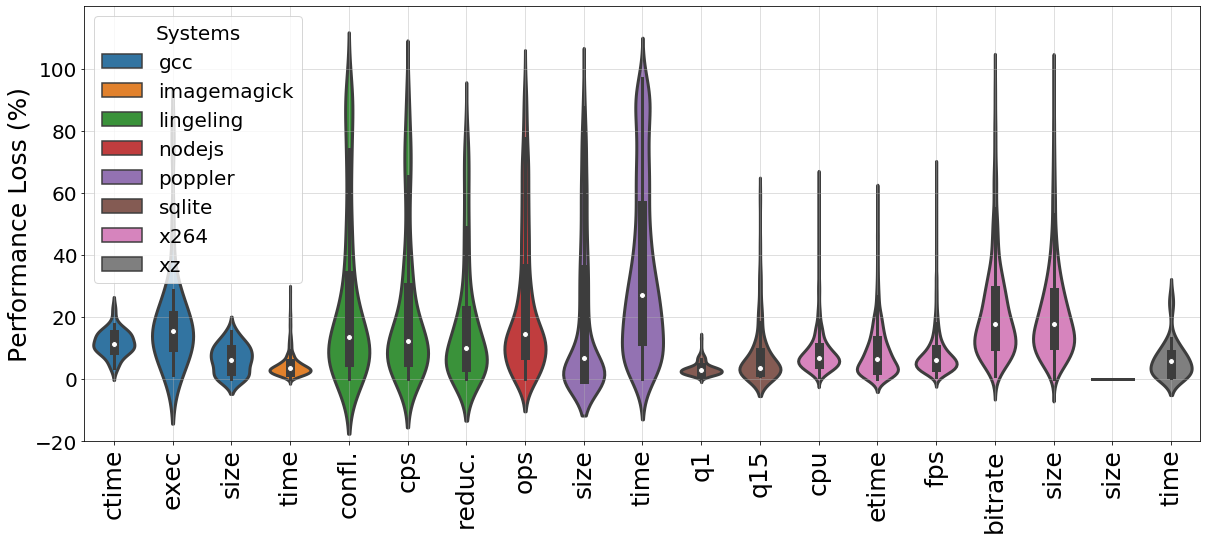

In [39]:
fig, ax = plt.subplots(figsize=((20,8)))

sns.violinplot(x=df["Performance"], y=df["Loss (%)"], hue = df["System"], linewidth=3, width = 0.7,
              scale_hue=True, saturation = 0.75, ax = ax, scale = "width", dodge = False)

ax.set_title("")
ax.set_xlabel("", size = 20)
ax.set_ylabel("Performance Loss (%)", size = 25)

plt.ylim(-10, 120)
plt.yticks([-20,0,20,40,60,80,100], size=20)

labs = [t.get_text().split('_')[1] if len(t.get_text().split('_')[1]) < 6 else t.get_text().split('_')[1][0:5]+'.' for t in ax.get_xticklabels()]
labs[15] = "bitrate"
ax.set_xticklabels(labs, size=25)
ax.xaxis.set_tick_params(rotation=90)

plt.legend(loc="upper left", frameon=True, fontsize=20, title = "Systems", title_fontsize=20)
plt.grid(alpha = 0.5)
plt.savefig('./RQ3-violon_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Complete results 

In [10]:
data_dir = "../../../data/"
name_systems = ["nodejs", "poppler", "xz", "x264", "gcc", "lingeling", "imagemagick"]

data = dict()
inputs_name = dict()
inputs_count = dict()
inputs_perf = dict()

inputs_perf["gcc"] = ["size", "ctime", "exec"]
inputs_perf["imagemagick"] = ["time"]
inputs_perf["lingeling"] = ["conflicts", "cps", "reductions"]
inputs_perf["nodejs"] = ["ops"]
inputs_perf["poppler"] = ["size", "time"]
inputs_perf["sqlite"] = ["q"+str(i+1) for i in range(15)]
inputs_perf["x264"] = ["size", "kbs", "fps", "etime", "cpu"]
inputs_perf["xz"] = ["size", "time"]


inputs_feat = dict()

inputs_feat["gcc"] = ["optim","-floop-interchange","-fprefetch-loop-arrays","-ffloat-store","-fno-asm"]
inputs_feat["imagemagick"] = ["memory_r", "posterize_r", "gaussian-blur", "thread", "quality"]
inputs_feat["lingeling"] = ["--boost", "--carduse", "--decompose", "--gluescale", "--lkhd", "--memlim", 
"--minimize", "--prbsimple", "--sweepirr", "--sweepred"]
inputs_feat["nodejs"] = ["--jitless", "--experimental-wasm-modules", "--experimental-vm-modules",
                         "--preserve-symlinks-main","--no-warnings","--node-memory-debug"]
inputs_feat["poppler"] = ["format","j","jp2","jbig2","ccitt"]
inputs_feat["sqlite"] = ["-deserialize", "-memtrace", "-maxsize", "-append", "-output"]
inputs_feat["x264"] = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", 
                "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]
inputs_feat["xz"] = ["memory","format","level","depth"]


inputs_categ = dict()

inputs_categ["gcc"] = ["optim"]
inputs_categ["imagemagick"] = []
inputs_categ["lingeling"] = []
inputs_categ["nodejs"] = []
inputs_categ["poppler"] = ["format"]
inputs_categ["sqlite"] = []
inputs_categ["x264"] = ['analyse', 'me', 'direct', 'deblock']
inputs_categ["xz"] = ['memory', 'format']

for ns in name_systems:
    
    data_path = data_dir+ns+'/'
    
    inputs = sorted(os.listdir(data_path))
    inputs.remove('others')

    inputs_name[ns] = inputs
    inputs_count[ns] = len(inputs)
    
    for i in range(len(inputs)):
        loc = data_path+inputs[i]
        data[ns, i] = pd.read_csv(loc)

In [11]:
complete_res = []
header = ["Avg", "Std", "$5^{th}$", "Q1", "Q2", "Q3", "$95^{th}$"]
ratio = dict()
for ns in sorted(name_systems):
    print("Results for",ns)
    for perf in sorted(inputs_perf[ns]):
        print("Results", perf)
        numbers = [np.round(k,2) for k in get_ratios(ns, perf)]
        complete_res.append(np.mean(numbers))
        disp=""
        for i in range(len(numbers)):
            disp+=" "+header[i]+" "+str(numbers[i]) 
        print(disp)

Results for gcc
Results ctime
 Avg 1.15 Std 0.05 $5^{th}$ 1.06 Q1 1.11 Q2 1.15 Q3 1.2 $95^{th}$ 1.22
Results exec
 Avg 1.37 Std 0.51 $5^{th}$ 1.02 Q1 1.1 Q2 1.23 Q3 1.43 $95^{th}$ 1.88
Results size
 Avg 1.24 Std 0.11 $5^{th}$ 1.09 Q1 1.19 Q2 1.21 Q3 1.26 $95^{th}$ 1.43
Results for imagemagick
Results time
 Avg 1.06 Std 0.05 $5^{th}$ 1.01 Q1 1.03 Q2 1.04 Q3 1.07 $95^{th}$ 1.14
Results for lingeling
Results conflicts
 Avg 1.91 Std 2.04 $5^{th}$ 1.02 Q1 1.06 Q2 1.15 Q3 1.49 $95^{th}$ 6.81
Results cps
 Avg 1.94 Std 3.3 $5^{th}$ 1.02 Q1 1.06 Q2 1.15 Q3 1.41 $95^{th}$ 5.43
Results reductions
 Avg 1.44 Std 0.77 $5^{th}$ 1.03 Q1 1.06 Q2 1.14 Q3 1.34 $95^{th}$ 3.11
Results for nodejs
Results ops
 Avg 1.77 Std 2.08 $5^{th}$ 1.01 Q1 1.09 Q2 1.17 Q3 1.57 $95^{th}$ 4.02
Results for poppler
Results size
 Avg 1.99 Std 2.03 $5^{th}$ 1.01 Q1 1.07 Q2 1.32 Q3 2.06 $95^{th}$ 5.04
Results time
 Avg 2.93 Std 4.12 $5^{th}$ 1.03 Q1 1.19 Q2 1.52 Q3 2.39 $95^{th}$ 11.3
Results for x264
Results cpu
 Avg 1.12 Std

In [12]:
print(np.mean(complete_res))

nan


In [13]:
complete_res = []
header = ["Avg", "Std", "$5^{th}$", "Q1", "Q2", "Q3", "$95^{th}$"]
ratio = dict()
for ns in sorted(name_systems):
    for perf in sorted(inputs_perf[ns]):
        numbers = [np.round(k,2) for k in get_ratios(ns, perf)]
        complete_res.append(np.mean(numbers))
        print('q2["'+ns+'","'+perf+'"] ='+str(numbers[4]))

q2["gcc","ctime"] =1.14
q2["gcc","exec"] =1.25
q2["gcc","size"] =1.21
q2["imagemagick","time"] =1.04
q2["lingeling","conflicts"] =1.14
q2["lingeling","cps"] =1.14
q2["lingeling","reductions"] =1.13
q2["nodejs","ops"] =1.17
q2["poppler","size"] =1.32
q2["poppler","time"] =1.51
q2["x264","cpu"] =1.08
q2["x264","etime"] =1.19
q2["x264","fps"] =1.07
q2["x264","kbs"] =1.27
q2["x264","size"] =1.27
q2["xz","size"] =nan
q2["xz","time"] =1.08
